In [11]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.calibration import calibration_curve
import matplotlib.tri as tri
from scipy.special import betaln
from scipy.stats import beta, norm
from scipy import stats
from scipy.special import gamma as gamma_fun
import scipy.special as spec
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np
np.set_printoptions(suppress=True)


from deep_bayes.models import DeepEvidentialModel
from deep_bayes.settings import EVIDENTIAL_BF
from deep_bayes.training import train_online
from deep_bayes.losses import log_loss
from deep_bayes.diagnostics import accuracy, expected_calibration_error
from deep_bayes.viz import plot_model_samples, plot_confusion_matrix

1.15.0


In [12]:
%load_ext autoreload
%autoreload 2

tf.enable_eager_execution()

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Plot model

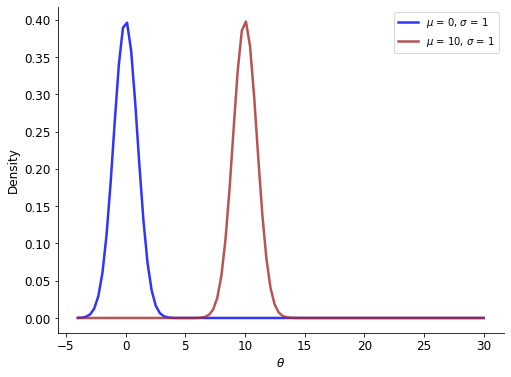

In [13]:
priors = ((0, 1), (10, 1))

plt.rcParams['font.size'] = 12
colors = ['blue', 'brown', 'green']
f, ax = plt.subplots(1, 1, figsize=(8, 6))
for i, (a, b) in enumerate(priors):
    distri = stats.norm(a, b)
    x = np.linspace(-4, 30, 100)
    x_pdf = distri.pdf(x)
    ax.plot(x, x_pdf, label=r'$\mu$ = {:d}, $\sigma$ = {:d}'.format(a, b), color=colors[i], lw=2.5, alpha=0.8)
    ax.set_ylabel('Density')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('$\\theta$')
    ax.legend(fontsize=10, loc=1)
f.savefig('figures/Models_toy.png', dpi=300, bbox_inches='tight')

## Model prior 
<p>Defines the prior probabilities over models $p(\boldsymbol{m})$.</p>

In [14]:
def model_prior(batch_size, n_models, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------
    
    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    n_models   : int  -- the number of generative models in queston
    ----------
    
    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1/n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

## Model parameters priors
<p>Defines how parameters are generated given a model $p(\boldsymbol{\theta}|\boldsymbol{m})$.</p>

In [15]:
def GA(n_samples):
    
    return np.random.normal(0, 1, n_samples)

def GB(n_samples):
    
    return np.random.normal(7, 1, n_samples)

def GC(n_samples):
    
    return np.random.normal(14, 1, n_samples)


## Data generator
<p>Define the algorithm:</p>
1. <strong>for</strong> $i = 1,...,B$<br>
2. &emsp;$\boldsymbol{m}^{(i)} \sim p(\boldsymbol{m})$<br>
3. &emsp;$\boldsymbol{\theta}^{(i)} \sim p(\boldsymbol{\theta}|\boldsymbol{m}^{(i)})$<br>
4. &emsp;$\boldsymbol{x}_{1:N}^{(i)} \sim p(\boldsymbol{x}|\boldsymbol{\theta}^{(i)},\boldsymbol{m}^{(i)})$

In [16]:
def data_generator(batch_size, model_prior, forward_models, alpha_smooth=None,
                   n_obs=None, n_obs_min=100, n_obs_max=500, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size     : int -- the number of samples to draw from the prior
    model_prior    : callable -- the prior which returns a sample of model indices
    param_priors   : list of callables -- a list with model prior samplers
    forward_models : list of generative models g(theta) -- a list of generatibve models
    n_obs          : int -- the numebr of observations to draw from p(x|theta)
    n_obs_min      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    n_obs_max      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    to_tensor      : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    m     : tf.Tensor or np.ndarray of shape (batch_size, n_models) - the one-hot encoded version of the models
    theta : tf.Tensor or np.ndarray of shape (batch_size, theta_dim) - the data gen parameters 
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from model prior
    # m_indices is an np.int32 array of model indices  
    n_models = len(forward_models)
    m_indices = model_prior(batch_size, n_models)

    # Sample N, if not specified
    if n_obs is None:
        n_obs = np.random.randint(low=n_obs_min, high=n_obs_max+1)
    
    # For each model index, sample from prior and run generative model.
    x = []
    theta = []
    for m_idx in m_indices:
        
        # Generate data from x = g_m(theta) <=> x ~ p(x|theta,m)
        x_m = forward_models[m_idx](n_obs)
        
        # Store data and params
        x.append(x_m.reshape(-1, 1))
#         theta.append(theta_m)
    
    # One-hot encode model indices
    m = to_categorical(m_indices, num_classes=n_models)
    
    # Apply label smoothing, if specified
    if alpha_smooth is not None:
        m = m * (1 - alpha_smooth) + alpha_smooth / n_models
    
    # Convert to tensor, if specified 
    if to_tensor:
#         theta = tf.convert_to_tensor(theta, dtype=tf.float32)
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        m = tf.convert_to_tensor(m, dtype=tf.float32)
    return {'m': m, 'x': x}

# Training hyperparameters (fixed N)

In [17]:
#--- Training hyperparameters ---#
n_obs = 100
n_test = 500
n_cal = 5000
alpha_smooth = None
epochs = 50
iterations_per_epoch = 1000


batch_size = 128
ckpt_file = 'toy_gaussian'

#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.001
decay_steps = 1000
decay_rate = .95

#--- Data generation ---#
# model_names = ['Model 1', 'Model 2']
# param_priors = [beta_wide_prior, beta_sharp_prior]
forward_models = [GA, GB]
data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   forward_models=forward_models,
                   n_obs=n_obs,
                   alpha_smooth=alpha_smooth)


# --- Optimizer --- #
global_step = tf.Variable(0, dtype=tf.int32)
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [18]:
model = DeepEvidentialModel(EVIDENTIAL_BF)

In [19]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Restored from ./checkpoints/toy_gaussian/ckpt-1


In [10]:
for ep in range(1, epochs + 1):
    with tqdm(total=iterations_per_epoch, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_online(model=model, 
                              optimizer=optimizer, 
                              data_gen=data_gen, 
                              loss_fun=partial(log_loss, lambd=0.5), 
                              iterations=iterations_per_epoch,
                              batch_size=batch_size,
                              p_bar=p_bar,
                              global_step=global_step,
                              method='evidence')
        manager.save()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



KeyboardInterrupt: 

In [21]:
batch_size = 1

n_obs = 200

n_models = len(forward_models)
m_indices = model_prior(batch_size, n_models)
  
# Sample N, if not specified
if n_obs is None:
    n_obs = np.random.randint(low=n_obs_min, high=n_obs_max+1)

# For each model index, sample from prior and run generative model.
x = []

for m_idx in m_indices:

    # Generate data from x = g_m(theta) <=> x ~ p(x|theta,m)
    x_m = np.random.normal(2, 1, n_obs)
    # Store data and params
    x.append(x_m.reshape(-1, 1))
#         theta.append(theta_m)

# One-hot encode model indices
m = to_categorical(m_indices, num_classes=n_models)


x = tf.convert_to_tensor(x, dtype=tf.float32)






# x = data_gen(1)
print(x.shape)

a = model.predict(x, to_numpy=True)
print(a)
# a['alpha'][0][0] = 2

(1, 200, 1)
{'alpha': <tf.Tensor: id=59551, shape=(1, 2), dtype=float32, numpy=array([[   1.    , 2849.0078]], dtype=float32)>, 'm_probs': array([[0.00035088, 0.9996491 ]], dtype=float32), 'm_var': array([[0.00000012, 0.00000012]], dtype=float32), 'uncertainty': array([[0.00070175]], dtype=float32)}


In [ ]:
S = model.sample(x, to_numpy=True)
np.mean()

In [ ]:
A = pd.DataFrame(
    a,
    columns = ['a'])
A.plot.hist(bins=20, alpha=0.5)

In [ ]:
from functools import reduce


def xy2bc(xy, corners, midpoints, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)


class Dirichlet:
    def __init__(self, alpha):
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) / reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])

    

def draw_pdf_contours(dist, nlevels=200, subdiv=8, ax=None, f=None, **kwargs):
    
    
    if ax is None and f is None:
        f, ax = plt.subplots(1, 1, figsize=(5, 5))
    
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy, corners, midpoints)) for xy in zip(trimesh.x, trimesh.y)]

    ax.tricontourf(trimesh, pvals, nlevels, **kwargs)
    return f

In [ ]:
d = Dirichlet(a['alpha'][0])
draw_pdf_contours(d, n_levels=100, subdiv=8, ax=None, f=None, cmap='viridis')